In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import time
from sklearn.metrics import mean_squared_error

'''
None || 20000 || 100000
'''
nb = None
nb_trains = nb
nb_valids = nb
nb_tests = nb

N_past = 10

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
cd drive/MyDrive/Projects/JPX_Tokyo_Stock/JPX_stock_2022/working

/content/drive/MyDrive/Projects/JPX_Tokyo_Stock/JPX_stock_2022/working


In [4]:
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import optuna
from data_utils import *

#### Load Data

In [6]:
train_df = pd.read_csv('../__input__/3_FeatureSelection/train_full.csv', nrows = nb_trains)
valid_df = pd.read_csv('../__input__/3_FeatureSelection/valid_full.csv', nrows = nb_trains)
test_df = pd.read_csv('../__input__/3_FeatureSelection/test_full.csv', nrows = nb_trains)

In [7]:
mini_train_DP = pd.read_csv('../__input__/1_DataPreprocessing/mini_train.csv', parse_dates=['Date'], nrows = None)
mini_train_FE = pd.read_csv('../__input__/2_FeatureEngineering/mini_train.csv', parse_dates=['Date'], nrows = None)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1843182 entries, 0 to 1843181
Data columns (total 34 columns):
 #   Column            Dtype  
---  ------            -----  
 0   ExpectedDividend  float64
 1   Year              int64  
 2   dayofyear         int64  
 3   is_month_start    bool   
 4   Day               int64  
 5   dayofweek         int64  
 6   is_month_end      bool   
 7   Close             float64
 8   Close_std         float64
 9   Close_lags_1      float64
 10  Close_lags_10     float64
 11  Close_mean        float64
 12  Close_lags_2      float64
 13  Close_lags_8      float64
 14  Close_lags_9      float64
 15  Range_HL_lags_9   float64
 16  Range_HL_lags_10  float64
 17  Close_lags_5      float64
 18  Close_lags_4      float64
 19  Range_HL_lags_8   float64
 20  Volume            float64
 21  Range_HL_lags_3   float64
 22  Close_lags_6      float64
 23  Range_OC_lags_3   float64
 24  Close_lags_3      float64
 25  Close_lags_7      float64
 26  Range_OC_lags_

In [9]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232663 entries, 0 to 232662
Data columns (total 34 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ExpectedDividend  232663 non-null  float64
 1   Year              232663 non-null  int64  
 2   dayofyear         232663 non-null  int64  
 3   is_month_start    232663 non-null  bool   
 4   Day               232663 non-null  int64  
 5   dayofweek         232663 non-null  int64  
 6   is_month_end      232663 non-null  bool   
 7   Close             232663 non-null  float64
 8   Close_std         232663 non-null  float64
 9   Close_lags_1      232663 non-null  float64
 10  Close_lags_10     232663 non-null  float64
 11  Close_mean        232663 non-null  float64
 12  Close_lags_2      232663 non-null  float64
 13  Close_lags_8      232663 non-null  float64
 14  Close_lags_9      232663 non-null  float64
 15  Range_HL_lags_9   232663 non-null  float64
 16  Range_HL_lags_10  23

In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198663 entries, 0 to 198662
Data columns (total 34 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ExpectedDividend  198663 non-null  float64
 1   Year              198663 non-null  int64  
 2   dayofyear         198663 non-null  int64  
 3   is_month_start    198663 non-null  bool   
 4   Day               198663 non-null  int64  
 5   dayofweek         198663 non-null  int64  
 6   is_month_end      198663 non-null  bool   
 7   Close             198663 non-null  float64
 8   Close_std         198663 non-null  float64
 9   Close_lags_1      198663 non-null  float64
 10  Close_lags_10     198663 non-null  float64
 11  Close_mean        198663 non-null  float64
 12  Close_lags_2      198663 non-null  float64
 13  Close_lags_8      198663 non-null  float64
 14  Close_lags_9      198663 non-null  float64
 15  Range_HL_lags_9   198663 non-null  float64
 16  Range_HL_lags_10  19

### Calc Scores

In [11]:
def calc_spread_return_per_day(df, portfolio_size: int = 200, toprank_weight_ratio: float = 2):
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): spread return
    """
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    buf = df.groupby('Date').apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio, buf

def add_rank(df: pd.DataFrame, y_pred):
    df["Pred"] = y_pred
    df["Rank"] = df.groupby("Date")["Pred"].rank(ascending=False, method="first") - 1 
    df = df.drop("Pred", axis= 1)
    return df

In [12]:
def calc_score(df: pd.DataFrame, y_pred: pd.DataFrame, y_true: pd.DataFrame, render_info= True):
    feature_df = df.copy()
    feature_df = add_rank(feature_df, y_pred)
    feature_df['Target'] = y_true
    score, buf = calc_spread_return_sharpe(feature_df)
    if render_info:
        print(f'score -> {score}\nmean -> {buf.mean()}\nstd -> {buf.std()}')
    del feature_df
    return score

In [13]:
calc_score(test_df, test_df["Target"], test_df["Target"])

score -> 4.7366694709759
mean -> 15.115996128121251
std -> 3.1912710440838277


4.7366694709759

### Cross Validation

In [14]:
featureCols = train_df.drop(["Target", "CloseT1", "CloseT2"], axis = 1).columns
featureCols

Index(['ExpectedDividend', 'Year', 'dayofyear', 'is_month_start', 'Day',
       'dayofweek', 'is_month_end', 'Close', 'Close_std', 'Close_lags_1',
       'Close_lags_10', 'Close_mean', 'Close_lags_2', 'Close_lags_8',
       'Close_lags_9', 'Range_HL_lags_9', 'Range_HL_lags_10', 'Close_lags_5',
       'Close_lags_4', 'Range_HL_lags_8', 'Volume', 'Range_HL_lags_3',
       'Close_lags_6', 'Range_OC_lags_3', 'Close_lags_3', 'Close_lags_7',
       'Range_OC_lags_6', 'Range_OC_lags_1', 'Range_HL_lags_4',
       'Range_OC_lags_2', 'Date'],
      dtype='object')

In [15]:
X_train = train_df[featureCols]
X_train["Date"] = X_train["Date"].astype(str)
y_train = train_df["Target"]

X_valid = valid_df[featureCols]
X_valid["Date"] = X_valid["Date"].astype(str)
y_valid = valid_df["Target"]

X_test = test_df[featureCols]
X_test["Date"] = X_test["Date"].astype(str)
yTest_true = test_df["Target"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [16]:
calc_score(X_test, yTest_true, yTest_true)

score -> 4.7366694709759
mean -> 15.115996128121251
std -> 3.1912710440838277


4.7366694709759

#### Optuna tuning

In [17]:
def objective(
    trial,
    random_state=22,
    n_jobs=-1,
):
    # XGBoost parameters
    params = {
        'tree_method':'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 5, 10) * 100,
        "max_depth": trial.suggest_int("max_depth", 4, 20),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
        "subsample": trial.suggest_loguniform("subsample", 0.6, 0.8),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 1000),
        "seed": random_state,
        "n_jobs": n_jobs,
        "early_stopping_rounds": 50,
        "eval_metric": "rmse"
        
    }
    
    model = xgb.XGBRegressor(**params) 

    model.fit(
        X_train.drop("Date", axis = 1),
        y_train,
        eval_set=[(X_valid.drop("Date", axis = 1), y_valid)],
        verbose=0,
    )
    y_pred = pd.DataFrame(model.predict(X_valid.drop("Date", axis = 1)), columns =['Target'])
    return calc_score(X_valid, y_pred, y_valid, render_info= False)

In [ ]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-07-20 03:51:11,571] A new study created in memory with name: no-name-570a2f7b-5d11-4a0e-93a1-ab2918bff286
[I 2022-07-20 03:53:31,830] Trial 0 finished with value: 0.13005274259120325 and parameters: {'n_estimators': 10, 'max_depth': 13, 'learning_rate': 0.01591261664854079, 'colsample_bytree': 0.35854901766795194, 'subsample': 0.7817673904891599, 'alpha': 0.044688534576912284, 'lambda': 1.133359818688517e-08, 'min_child_weight': 32.65276910083693}. Best is trial 0 with value: 0.13005274259120325.
[I 2022-07-20 03:54:45,823] Trial 1 finished with value: 0.14163456056167043 and parameters: {'n_estimators': 8, 'max_depth': 12, 'learning_rate': 0.016377038337547493, 'colsample_bytree': 0.22413563033939235, 'subsample': 0.687839093291459, 'alpha': 0.048730875921274494, 'lambda': 0.19263350277967237, 'min_child_weight': 284.3980063011354}. Best is trial 1 with value: 0.14163456056167043.
[I 2022-07-20 03:55:10,672] Trial 2 finished with value: 0.22460539873321048 and parameters: {'n_

Number of finished trials: 30
Best trial: {'n_estimators': 6, 'max_depth': 5, 'learning_rate': 0.01858596676232182, 'colsample_bytree': 0.23889817997803603, 'subsample': 0.6377077399792583, 'alpha': 0.12524672107084342, 'lambda': 9.054854664621155e-08, 'min_child_weight': 746.856041018876}
CPU times: user 35min 30s, sys: 27.9 s, total: 35min 58s
Wall time: 35min 53s


In [18]:
best_params = {'alpha': 0.12524672107084342,
 'colsample_bytree': 0.23889817997803603,
 'early_stopping_rounds': 50,
 'eval_metric': 'rmse',
 'lambda': 9.054854664621155e-08,
 'learning_rate': 0.01858596676232182,
 'max_depth': 5,
 'min_child_weight': 746.856041018876,
 'n_estimators': 600,
 'n_jobs': -1,
 'objective': 'reg:squarederror',
 'seed': 22,
 'subsample': 0.6377077399792583,
 'tree_method': 'gpu_hist',
 'verbosity': 0}

best_params

{'alpha': 0.12524672107084342,
 'colsample_bytree': 0.23889817997803603,
 'early_stopping_rounds': 50,
 'eval_metric': 'rmse',
 'lambda': 9.054854664621155e-08,
 'learning_rate': 0.01858596676232182,
 'max_depth': 5,
 'min_child_weight': 746.856041018876,
 'n_estimators': 600,
 'n_jobs': -1,
 'objective': 'reg:squarederror',
 'seed': 22,
 'subsample': 0.6377077399792583,
 'tree_method': 'gpu_hist',
 'verbosity': 0}

In [19]:
# best_params = study.best_trial.params
# best_params['n_estimators'] *= 100

# best_params['tree_method'] = 'gpu_hist'
# best_params['verbosity'] = 0
# best_params['objective'] = "reg:squarederror"
# best_params['seed'] = 22
# best_params['n_jobs'] = -1
# best_params["early_stopping_rounds"] = 50
# best_params["eval_metric"] = "rmse"

# best_params

In [20]:
%%time
model = xgb.XGBRegressor(**best_params) 

model.fit(
    X_train.drop("Date", axis = 1),
    y_train,
    eval_set=[(X_valid.drop("Date", axis = 1), y_valid)],
    verbose=0,
)

CPU times: user 24.7 s, sys: 1.33 s, total: 26.1 s
Wall time: 25.9 s


In [21]:
%%time
y_pred = pd.DataFrame(model.predict(X_train.drop("Date", axis = 1)), columns =['Target'])
print(calc_score(X_train, y_pred, y_train, render_info= False))

0.5267757051936905
CPU times: user 7.27 s, sys: 907 ms, total: 8.18 s
Wall time: 8.11 s


In [22]:
np.sqrt(mean_squared_error(y_pred, y_train))

0.022336983207693343

In [23]:
%%time
y_pred = pd.DataFrame(model.predict(X_valid.drop("Date", axis = 1)), columns =['Target'])
print(calc_score(X_valid, y_pred, y_valid, render_info= False))

0.21147195780550093
CPU times: user 907 ms, sys: 80.1 ms, total: 987 ms
Wall time: 981 ms


In [24]:
np.sqrt(mean_squared_error(y_pred, y_valid))

0.021201755401873246

In [25]:
%%time
model = xgb.XGBRegressor(**best_params) 

model.fit(
    pd.DataFrame([]).append([X_train, X_valid]).drop("Date", axis = 1),
    pd.Series([]).append([y_train, y_valid]),
    verbose=0,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


CPU times: user 25 s, sys: 840 ms, total: 25.8 s
Wall time: 25.7 s


In [26]:
%%time
y_pred = pd.DataFrame(model.predict(X_test.drop("Date", axis = 1)), columns =['Target'])
print(calc_score(X_test, y_pred, yTest_true, render_info= False))

0.048171775538275924
CPU times: user 743 ms, sys: 82.1 ms, total: 825 ms
Wall time: 821 ms


In [27]:
np.sqrt(mean_squared_error(y_pred, yTest_true))

0.02422616613273122

In [28]:
def render_feature_important(model_xgboost, df_trained):
  feature_important = model.feature_importances_
  sorted_idx = np.argsort(feature_important)[::-1]

  keys = df_trained.columns[sorted_idx]
  values = feature_important[sorted_idx]

  data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
  data.plot(kind='barh', figsize = (20,10))

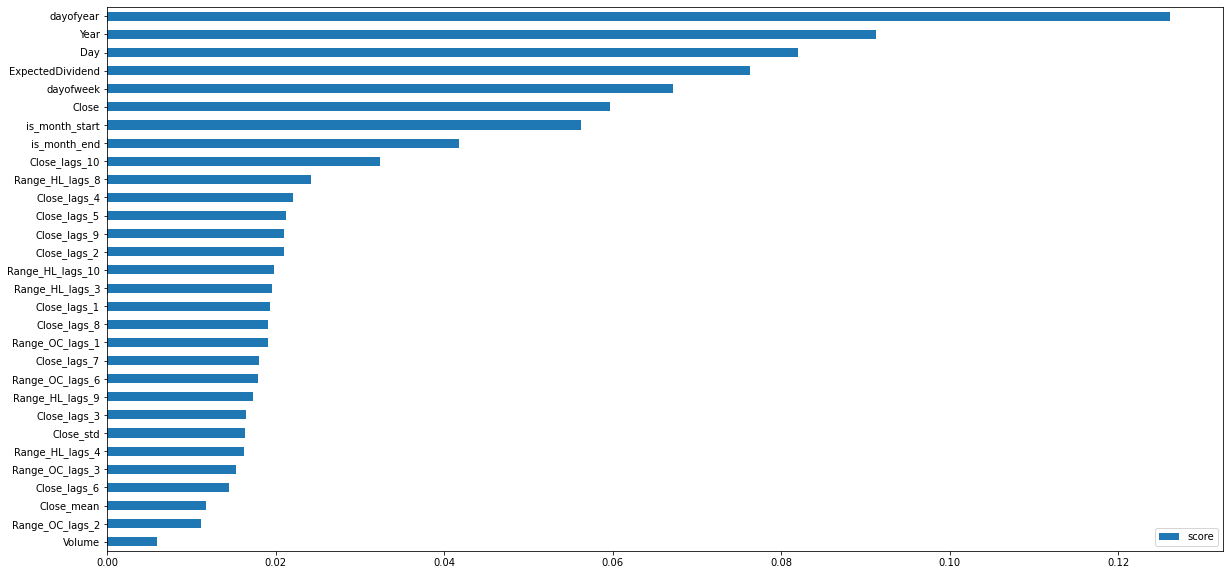

In [29]:
render_feature_important(model, X_train.drop("Date", axis = 1))